In [ ]:
# ============================================================
# CELL 1 - Setup ambiente, seed, import
# ============================================================
from google.colab import drive
drive.mount("/gdrive")

# Seed
SEED = 42

import os
import random
import warnings
warnings.filterwarnings("ignore")

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import numpy as np
np.random.seed(SEED)
random.seed(SEED)

import torch
torch.manual_seed(SEED)

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from PIL import Image
import pandas as pd
from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

!pip install -q lion-pytorch transformers

from transformers import AutoModel, AutoImageProcessor
from lion_pytorch import Lion

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Device
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print("Device:", device)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Device: cuda


In [ ]:
# ============================================================
# CELL 2 - Path, CSV, pulizia dataset
# ============================================================
current_dir    = "/gdrive/My Drive/[2025-2026] AN2DL/Challenge 2/dataset"
train_data_dir = f"{current_dir}/train_data"
test_data_dir  = f"{current_dir}/test_data"
csv_path       = f"{current_dir}/train_labels.csv"

df = pd.read_csv(csv_path)
if "sample_index" not in df.columns:
    df.columns = ["sample_index", "label"]

# ---- Filtra sample senza maschera ----
all_files = set(os.listdir(train_data_dir))
valid_imgs = {
    f for f in all_files
    if f.startswith("img_") and f.replace("img_", "mask_") in all_files
}

df = df[df["sample_index"].isin(valid_imgs)]
print("Dopo filtro img+mask:", len(df))

# ---- Rimozione sample sporchi / contaminati ----
SAMPLES_TO_IGNORE = [
    "img_0001.png","img_0005.png","img_0008.png","img_0012.png","img_0018.png","img_0020.png","img_0022.png","img_0027.png","img_0028.png","img_0036.png",
    "img_0044.png","img_0047.png","img_0048.png","img_0052.png","img_0062.png","img_0078.png","img_0085.png","img_0090.png","img_0094.png","img_0095.png",
    "img_0126.png","img_0129.png","img_0130.png","img_0133.png","img_0136.png","img_0138.png","img_0148.png","img_0150.png","img_0155.png","img_0159.png",
    "img_0161.png","img_0175.png","img_0178.png","img_0179.png","img_0180.png","img_0184.png","img_0187.png","img_0189.png","img_0193.png","img_0196.png",
    "img_0222.png","img_0251.png","img_0254.png","img_0263.png","img_0268.png","img_0286.png","img_0293.png","img_0313.png","img_0319.png","img_0333.png",
    "img_0342.png","img_0344.png","img_0346.png","img_0355.png","img_0368.png","img_0371.png","img_0376.png","img_0380.png","img_0390.png","img_0393.png",
    "img_0407.png","img_0410.png","img_0415.png","img_0424.png","img_0443.png","img_0453.png","img_0459.png","img_0463.png","img_0486.png","img_0497.png",
    "img_0498.png","img_0499.png","img_0509.png","img_0521.png","img_0530.png","img_0531.png","img_0533.png","img_0537.png","img_0540.png","img_0544.png",
    "img_0547.png","img_0557.png","img_0558.png","img_0560.png","img_0565.png","img_0567.png","img_0572.png","img_0578.png","img_0580.png","img_0586.png",
    "img_0602.png","img_0603.png","img_0607.png","img_0609.png","img_0614.png","img_0620.png","img_0623.png","img_0629.png","img_0635.png","img_0639.png",
    "img_0643.png","img_0644.png","img_0645.png","img_0646.png","img_0656.png","img_0657.png","img_0658.png","img_0670.png","img_0673.png","img_0675.png"
]

df = df[~df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(drop=True)
print("Dopo rimozione SAMPLES_TO_IGNORE:", len(df))

# ---- Label mapping ----
class_names = sorted(df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
df["label_index"] = df["label"].map(label_to_index)
num_classes = len(class_names)
print("Classi:", num_classes, class_names)

# ---- Train/Val split ----
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=SEED
)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")


Dopo filtro img+mask: 691
Dopo rimozione SAMPLES_TO_IGNORE: 581
Classi: 4 ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Train samples: 464, Val samples: 117


In [ ]:
# ============================================================
# CELL 3 - Processor Phikon-v2 LARGE
# ============================================================
MODEL_NAME = "owkin/phikon-v2"

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

IMAGENET_MEAN = processor.image_mean
IMAGENET_STD  = processor.image_std
INPUT_SIZE    = processor.size.get("shortest_edge", 224)

print("MODEL_NAME:", MODEL_NAME)
print("INPUT_SIZE:", INPUT_SIZE)
print("MEAN:", IMAGENET_MEAN)
print("STD :", IMAGENET_STD)


MODEL_NAME: owkin/phikon-v2
INPUT_SIZE: 224
MEAN: [0.485, 0.456, 0.406]
STD : [0.229, 0.224, 0.225]


In [ ]:
# ============================================================
# CELL 4 - Dataset patch-based (train/val)
# ============================================================
class MaskedCropDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, padding=5, max_patches=6):
        self.samples = []
        self.transform = transform
        self.img_dir = img_dir
        self.padding = padding
        self.max_patches = max_patches  # B: media = 6 patch max per immagine

        for _, row in dataframe.iterrows():
            img_name = row["sample_index"]
            label = row["label_index"]

            img_path  = os.path.join(img_dir, img_name)
            mask_path = os.path.join(img_dir, img_name.replace("img_", "mask_"))

            image = np.array(Image.open(img_path).convert("RGB"))
            mask  = (np.array(Image.open(mask_path).convert("L")) > 0)

            labeled_mask, n_comp = ndimage.label(mask)
            local_patches = []

            for cid in range(1, n_comp + 1):
                ys, xs = np.where(labeled_mask == cid)
                if len(xs) < 15:
                    continue

                x1, x2 = xs.min(), xs.max()
                y1, y2 = ys.min(), ys.max()

                h, w = image.shape[:2]

                # bbox con padding
                x1 = max(0, x1 - self.padding)
                y1 = max(0, y1 - self.padding)
                x2 = min(w, x2 + self.padding)
                y2 = min(h, y2 + self.padding)

                # rendi quadrata la bbox
                box_w = x2 - x1
                box_h = y2 - y1
                side = max(box_w, box_h)

                cx = (x1 + x2) // 2
                cy = (y1 + y2) // 2
                half = side // 2

                x1_sq = max(0, cx - half)
                y1_sq = max(0, cy - half)
                x2_sq = min(w, x1_sq + side)
                y2_sq = min(h, y1_sq + side)

                patch = image[y1_sq:y2_sq, x1_sq:x2_sq]
                local_patches.append((patch, label))

            # limita il numero massimo di patch per immagine
            if len(local_patches) > self.max_patches:
                local_patches = random.sample(local_patches, self.max_patches)

            self.samples.extend(local_patches)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        patch, label = self.samples[idx]
        patch = Image.fromarray(patch)
        if self.transform:
            patch = self.transform(patch)
        return patch, label


In [ ]:
# ============================================================
# CELL 5 - Transforms e DataLoader
# ============================================================

# Transform più "soft" per Transfer Learning
train_transform_tl = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Transform più "aggressiva" per Fine-Tuning
train_transform_ft = transforms.Compose([
    transforms.RandomResizedCrop(
        INPUT_SIZE,
        scale=(0.7, 1.0),
        ratio=(0.75, 1.33),
        antialias=True
    ),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(180),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Dataset per TL
train_dataset = MaskedCropDataset(train_df, train_data_dir, transform=train_transform_tl, max_patches=6)
val_dataset   = MaskedCropDataset(val_df,   train_data_dir, transform=val_transform,   max_patches=6)

def make_loader(ds, batch_size, shuffle):
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4
    )

BATCH_SIZE = 32

train_loader_tl = make_loader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader_tl   = make_loader(val_dataset,   BATCH_SIZE, shuffle=False)

print("Train patches (TL):", len(train_dataset), "Val patches:", len(val_dataset))


Train patches (TL): 2737 Val patches: 708


In [ ]:
# ============================================================
# CELL 6 - Modello Phikon-v2 + testa MLP
# ============================================================
class PhikonV2Classifier(nn.Module):
    def __init__(self, num_classes, dropout=0.3, freeze_backbone=True, model_name="owkin/phikon-v2"):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_dim = self.backbone.config.hidden_size  # phikon-v2: in genere 1024

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [B, hidden_dim]
        logits = self.classifier(cls_token)
        return logits


# modello per TRANSFER LEARNING: backbone congelato
tl_model = PhikonV2Classifier(
    num_classes=num_classes,
    dropout=0.3,
    freeze_backbone=True,
    model_name=MODEL_NAME
).to(device)


In [ ]:
# ============================================================
# CELL 7 - Training utilities + Early Stopping
# ============================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1   = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_f1


def val_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x)
                loss = criterion(logits, y)

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1   = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_f1


def fit(
    model,
    train_loader,
    val_loader,
    device,
    epochs,
    optimizer,
    scheduler=None,
    patience=20,
    ckpt_path="best_model.pt",
    tag="TL"
):
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    best_f1 = -1
    best_epoch = 0
    wait = 0

    history = {
        "train_loss": [],
        "train_f1": [],
        "val_loss": [],
        "val_f1": []
    }

    print(f"=== Training {tag} per {epochs} epoche ===")
    for epoch in range(1, epochs+1):
        train_loss, train_f1 = train_one_epoch(model, train_loader, optimizer, scaler, device)
        val_loss, val_f1     = val_one_epoch(model,   val_loader,   device)

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        if scheduler is not None:
            # usiamo il val_f1 per ReduceLROnPlateau
            scheduler.step(val_f1)

        print(
            f"[{tag}] Epoch {epoch:03d} | "
            f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
            f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}"
        )

        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), ckpt_path)
            wait = 0
            print(f"  ✓ New best {tag} model saved (F1={best_f1:.4f})")
        else:
            wait += 1
            print(f"  No improvement ({wait}/{patience})")

        if wait >= patience:
            print(f"⛔ Early stopping {tag} a epoch {epoch}, best epoch: {best_epoch} (F1={best_f1:.4f})")
            break

    # restore best
    model.load_state_dict(torch.load(ckpt_path))
    print(f"Best {tag} model restored from epoch {best_epoch} with F1={best_f1:.4f}")

    return model, history


In [ ]:
# ============================================================
# CELL 8 - Transfer Learning (TL)
# ============================================================
EPOCHS_TL = 200
LR_TL     = 1e-4
WD        = 1e-2
PATIENCE  = 20

optimizer_tl = Lion(
    tl_model.classifier.parameters(),   # solo testa
    lr=LR_TL,
    weight_decay=WD
)

scheduler_tl = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_tl,
    mode="max",
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=1e-6,
)

tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader_tl,
    val_loader=val_loader_tl,
    device=device,
    epochs=EPOCHS_TL,
    optimizer=optimizer_tl,
    scheduler=scheduler_tl,
    patience=PATIENCE,
    ckpt_path="phikon_v2_TL.pt",
    tag="TL"
)

print("Max Val F1 (TL):", max(tl_history["val_f1"]))


=== Training TL per 200 epoche ===
[TL] Epoch 001 | Train: Loss=1.2495, F1=0.3449 | Val: Loss=1.2524, F1=0.3246
  ✓ New best TL model saved (F1=0.3246)
[TL] Epoch 002 | Train: Loss=1.1116, F1=0.4893 | Val: Loss=1.3062, F1=0.3344
  ✓ New best TL model saved (F1=0.3344)
[TL] Epoch 003 | Train: Loss=1.0155, F1=0.5516 | Val: Loss=1.3294, F1=0.3322
  No improvement (1/20)
[TL] Epoch 004 | Train: Loss=0.9346, F1=0.6072 | Val: Loss=1.3848, F1=0.3174
  No improvement (2/20)
[TL] Epoch 005 | Train: Loss=0.8591, F1=0.6379 | Val: Loss=1.3475, F1=0.3316
  No improvement (3/20)
[TL] Epoch 006 | Train: Loss=0.7767, F1=0.6921 | Val: Loss=1.3637, F1=0.3321
  No improvement (4/20)
[TL] Epoch 007 | Train: Loss=0.7089, F1=0.7276 | Val: Loss=1.4468, F1=0.3219
  No improvement (5/20)
[TL] Epoch 008 | Train: Loss=0.6427, F1=0.7621 | Val: Loss=1.5006, F1=0.3237
  No improvement (6/20)
[TL] Epoch 009 | Train: Loss=0.5718, F1=0.8048 | Val: Loss=1.5209, F1=0.3361
  ✓ New best TL model saved (F1=0.3361)
[TL] Epo

In [ ]:
# ============================================================
# CELL 9 - Fine-Tuning (FT) leggero
# ============================================================

# 1) aggiorna l'augmentation del train (più forte)
train_dataset.transform = train_transform_ft
train_loader_ft = make_loader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader_ft   = make_loader(val_dataset,   BATCH_SIZE, shuffle=False)

# 2) nuovo modello con backbone sbloccato
ft_model = PhikonV2Classifier(
    num_classes=num_classes,
    dropout=0.3,
    freeze_backbone=False,
    model_name=MODEL_NAME
).to(device)

# 3) carichiamo i pesi TL (solo testa addestrata)
ft_model.load_state_dict(torch.load("phikon_v2_TL.pt"), strict=False)

# 4) congeliamo TUTTI i blocchi, poi sblocchiamo SOLO gli ultimi 6
for p in ft_model.backbone.parameters():
    p.requires_grad = False

# NOTA: phikon-v2 è un ViT, di solito backbone.encoder.layer è la lista dei blocchi
for block in ft_model.backbone.encoder.layer[-6:]:
    for p in block.parameters():
        p.requires_grad = True

# 5) parametri per optimizer con LR diversi
head_params = list(ft_model.classifier.parameters())
backbone_trainable = [p for p in ft_model.backbone.parameters() if p.requires_grad]

optimizer_ft = Lion(
    [
        {"params": head_params,        "lr": 3e-5},  # testa più aggressiva
        {"params": backbone_trainable, "lr": 1e-5},  # backbone più cauto
    ],
    lr=1e-5,  # default, non usato davvero
    weight_decay=WD
)

scheduler_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft,
    mode="max",
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=1e-6,
)

EPOCHS_FT = 200

ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_loader_ft,
    val_loader=val_loader_ft,
    device=device,
    epochs=EPOCHS_FT,
    optimizer=optimizer_ft,
    scheduler=scheduler_ft,
    patience=PATIENCE,
    ckpt_path="phikon_v2_FT.pt",
    tag="FT"
)

print("Max Val F1 (FT):", max(ft_history["val_f1"]))


=== Training FT per 200 epoche ===
[FT] Epoch 001 | Train: Loss=1.2858, F1=0.4537 | Val: Loss=1.6701, F1=0.3207
  ✓ New best FT model saved (F1=0.3207)
[FT] Epoch 002 | Train: Loss=1.0288, F1=0.5389 | Val: Loss=1.6829, F1=0.2963
  No improvement (1/20)
[FT] Epoch 003 | Train: Loss=0.9602, F1=0.5856 | Val: Loss=1.7211, F1=0.3031
  No improvement (2/20)
[FT] Epoch 004 | Train: Loss=0.9235, F1=0.5971 | Val: Loss=1.7337, F1=0.2906
  No improvement (3/20)
[FT] Epoch 005 | Train: Loss=0.8863, F1=0.6288 | Val: Loss=1.7542, F1=0.3002
  No improvement (4/20)
[FT] Epoch 006 | Train: Loss=0.8507, F1=0.6453 | Val: Loss=1.7701, F1=0.3028
  No improvement (5/20)
[FT] Epoch 007 | Train: Loss=0.8252, F1=0.6669 | Val: Loss=1.8104, F1=0.3117
  No improvement (6/20)
[FT] Epoch 008 | Train: Loss=0.7994, F1=0.6730 | Val: Loss=1.7847, F1=0.3221
  ✓ New best FT model saved (F1=0.3221)
[FT] Epoch 009 | Train: Loss=0.7663, F1=0.6836 | Val: Loss=1.8063, F1=0.3116
  No improvement (1/20)
[FT] Epoch 010 | Train: 

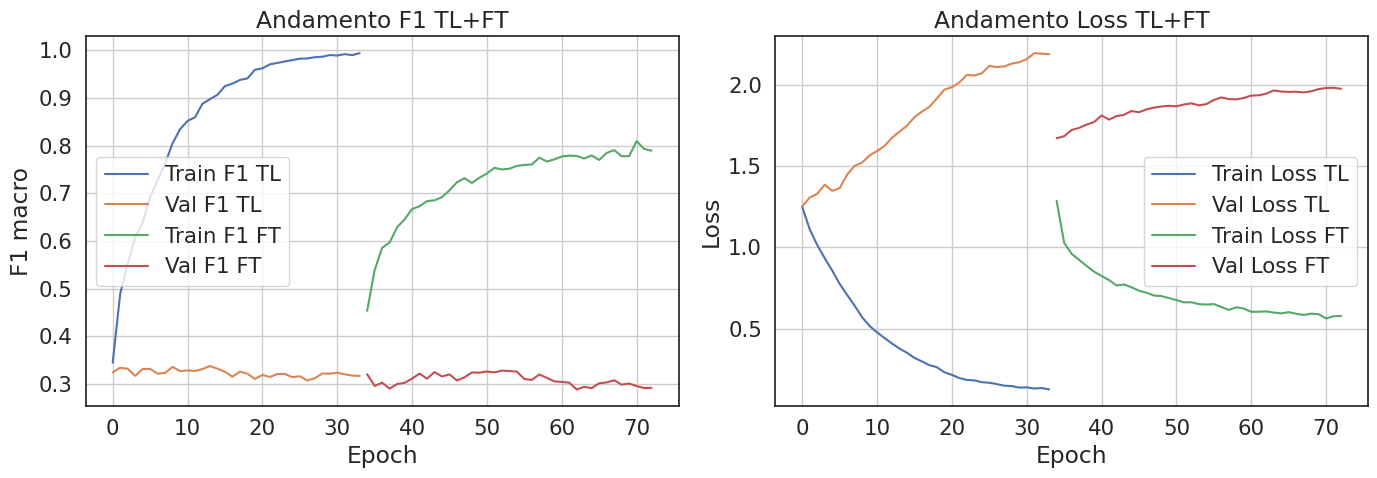

In [ ]:
# ============================================================
# CELL 10 - Plot TL vs FT
# ============================================================
def plot_history(tl_history, ft_history):
    epochs_tl = len(tl_history["val_f1"])
    epochs_ft = len(ft_history["val_f1"])

    plt.figure(figsize=(14,5))

    # F1
    plt.subplot(1,2,1)
    plt.plot(tl_history["train_f1"], label="Train F1 TL")
    plt.plot(tl_history["val_f1"],   label="Val F1 TL")
    plt.plot(range(epochs_tl, epochs_tl+epochs_ft),
             ft_history["train_f1"], label="Train F1 FT")
    plt.plot(range(epochs_tl, epochs_tl+epochs_ft),
             ft_history["val_f1"],   label="Val F1 FT")
    plt.xlabel("Epoch")
    plt.ylabel("F1 macro")
    plt.title("Andamento F1 TL+FT")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(tl_history["train_loss"], label="Train Loss TL")
    plt.plot(tl_history["val_loss"],   label="Val Loss TL")
    plt.plot(range(epochs_tl, epochs_tl+epochs_ft),
             ft_history["train_loss"], label="Train Loss FT")
    plt.plot(range(epochs_tl, epochs_tl+epochs_ft),
             ft_history["val_loss"],   label="Val Loss FT")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Andamento Loss TL+FT")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(tl_history, ft_history)


In [ ]:
# ============================================================
# CELL 11 - TTA su tensor normalizzato
# ============================================================
def tta_from_tensor(tensor_img, model, device):
    """
    tensor_img: [C,H,W] già normalizzato (val_transform)
    """
    augs = [
        lambda t: t,
        lambda t: TF.hflip(t),
        lambda t: TF.vflip(t),
        lambda t: TF.rotate(t, 90),
        lambda t: TF.rotate(t, -90),
    ]

    outputs = []
    model.eval()
    with torch.no_grad():
        for fn in augs:
            aug = fn(tensor_img).unsqueeze(0).to(device)  # [1,C,H,W]
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(aug)
            prob = F.softmax(logits, dim=1).cpu()  # [1, num_classes]
            outputs.append(prob)

    return torch.stack(outputs).mean(dim=0).squeeze(0)  # [num_classes]


In [ ]:
# ============================================================
# CELL 12 - Dataset TEST a patch
# ============================================================
class TestPatches(Dataset):
    def __init__(self, img_dir, padding=5, transform=None):
        self.samples = []
        self.img_dir = img_dir
        self.padding = padding
        self.transform = transform

        for img_name in sorted(f for f in os.listdir(img_dir) if f.startswith("img_")):
            img_path  = os.path.join(img_dir, img_name)
            mask_path = os.path.join(img_dir, img_name.replace("img_", "mask_"))

            image = np.array(Image.open(img_path).convert("RGB"))
            mask  = (np.array(Image.open(mask_path).convert("L")) > 0)

            labeled_mask, n_components = ndimage.label(mask)

            for cid in range(1, n_components + 1):
                ys, xs = np.where(labeled_mask == cid)
                if len(xs) < 15:
                    continue

                x1, x2 = xs.min(), xs.max()
                y1, y2 = ys.min(), ys.max()

                h, w = image.shape[:2]

                x1 = max(0, x1 - self.padding)
                y1 = max(0, y1 - self.padding)
                x2 = min(w, x2 + self.padding)
                y2 = min(h, y2 + self.padding)

                box_w = x2 - x1
                box_h = y2 - y1
                side = max(box_w, box_h)

                cx = (x1 + x2) // 2
                cy = (y1 + y2) // 2
                half = side // 2

                x1_sq = max(0, cx - half)
                y1_sq = max(0, cy - half)
                x2_sq = min(w, x1_sq + side)
                y2_sq = min(h, y1_sq + side)

                patch = image[y1_sq:y2_sq, x1_sq:x2_sq]
                self.samples.append((patch, img_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        patch, img_name = self.samples[idx]
        patch = Image.fromarray(patch)
        if self.transform:
            patch = self.transform(patch)   # tensor [C,H,W]
        return patch, img_name


In [ ]:
# ============================================================
# CELL 13 - Inference + soft voting pesato + submission
# ============================================================
# Dataset / DataLoader test
test_dataset = TestPatches(
    img_dir=test_data_dir,
    padding=5,
    transform=val_transform  # stessa normalizzazione della val
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    pin_memory_device="cuda" if torch.cuda.is_available() else ""
)

# Carichiamo il best model FT
best_model = PhikonV2Classifier(
    num_classes=num_classes,
    dropout=0.3,
    freeze_backbone=False,
    model_name=MODEL_NAME
).to(device)

best_model.load_state_dict(torch.load("phikon_v2_FT.pt"))
best_model.eval()

from collections import defaultdict

votes = defaultdict(list)

with torch.no_grad():
    for patch_tensor, img_name in test_loader:
        patch_tensor = patch_tensor[0]  # [C,H,W]

        prob = tta_from_tensor(patch_tensor, best_model, device)  # [num_classes]

        img = img_name[0]
        votes[img].append(prob)

# Aggregazione per immagine (weighted soft voting)
final_preds = {}

for img, plist in votes.items():
    probs = torch.stack(plist)          # [num_patches, num_classes]
    conf  = probs.max(dim=1).values     # confidenza per patch
    weights = conf / conf.sum()         # normalizzazione

    weighted_prob = (probs * weights[:, None]).sum(dim=0)
    final_preds[img] = weighted_prob.argmax().item()

image_names = sorted(final_preds.keys())

submission_df = pd.DataFrame({
    "sample_index": image_names,
    "label": [class_names[final_preds[f]] for f in image_names]
})

os.makedirs(f"{current_dir}/submission", exist_ok=True)
submission_path = f"{current_dir}/submission/Phikon_v2_TLFT_TTA_weighted.csv"
submission_df.to_csv(submission_path, index=False)

print("Saved submission:", submission_path)
print("Num rows:", len(submission_df))
submission_df.head()


Saved submission: /gdrive/My Drive/[2025-2026] AN2DL/Challenge 2/dataset/submission/Phikon_v2_TLFT_TTA_weighted.csv
Num rows: 477


,sample_index,label
0,img_0000.png,Luminal B
1,img_0001.png,Luminal B
2,img_0002.png,Luminal B
3,img_0003.png,Luminal B
4,img_0004.png,Luminal B
